# Visualize personal Gmail inbox traffic over time

This is a demonstration of working with time series in Python, in which I visualize my personal Gmail account traffic since signing up in 2004. It excludes work and school email traffic, as I have/had dedicated separate email accounts for each. It also excludes the Hangouts/chats that Google includes in your mbox archive. 

Visit https://accounts.google.com/ServiceLogin?service=backup to download your gmail archive as a .mbox file

In [2]:
import mailbox, pandas as pd, numpy as np 
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
from dateutil.parser import parse as parse_datetime
%matplotlib inline

In [3]:
# define the fonts to use for plots
family = 'Myriad Pro'
title_font = fm.FontProperties(family=family, style='normal', size=20, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=12, weight='normal', stretch='normal')

## Load the Gmail archive and parse dates/times from messages

In [4]:
# load the mbox file
path = 'gmail.mbox'
mbox = mailbox.mbox(path)
print('There are {:,} messages in the archive.'.format(len(mbox)))

There are 6,098 messages in the archive.


The Gmail mbox file includes emails and hangouts chats among its "messages". Hangouts messages don't have date/time, so we'll only parse dates and times from the actual emails, and just ignore the hangouts chats. Also, some chats do have a date. To filter them out, verify that *if* the message has a label that the label does *not* include "Chat".

In [6]:
# get a list of the dates/times of all the messages in the mbox
all_dates = []
all_times = []
for message in mbox:
    # it's an email and not a chat if there's no label, or if there's a label but it's not 'chat'
    if not 'X-Gmail-Labels' in message or ('X-Gmail-Labels' in message and not 'Chat' in message['X-Gmail-Labels']):
        if 'Date' in message and message['Date'] is not None:
            try:
                date, time = str(parse_datetime(message['Date'])).split(' ')
            except Exception as e:
                print(e, message['Date'])
            all_dates.append(date)
            all_times.append(time)
        else:
            # hangouts messages have no Date key, so skip them
            pass
print('There are {:,} messages with dates.'.format(len(all_dates)))

('Unknown string format:', 'Tue, 5 Jun 2018 00:53:02 +0530 (GMT+05:30)') Tue, 5 Jun 2018 00:53:02 +0530 (GMT+05:30)
('Unknown string format:', 'Tue, 5 Jun 2018 00:07:58 +0530 (GMT+05:30)') Tue, 5 Jun 2018 00:07:58 +0530 (GMT+05:30)
('Unknown string format:', 'Tue, 11 Nov 2014 19:16:56 +0530 (GMT+05:30)') Tue, 11 Nov 2014 19:16:56 +0530 (GMT+05:30)
There are 6,098 messages with dates.


## Plot the Gmail traffic by date

In [7]:
# get the count per date
date_counts = pd.Series(all_dates).value_counts().sort_index()
print('There are {:,} dates with messages.'.format(len(date_counts)))
date_counts.head()

There are 1,179 dates with messages.


2013-01-21    1
2013-01-31    1
2013-02-07    1
2013-02-14    1
2013-03-27    1
dtype: int64

In [8]:
# not every date necessarily has a message, so fill in missing dates in the range with zeros
date_range = pd.date_range(start=min(all_dates), end=max(all_dates), freq='D')
index = date_range.map(lambda x: str(x.date()))
date_counts = date_counts.reindex(index, fill_value=0)

print('There are {:,} dates total in the range, with or without messages.'.format(len(date_counts)))
date_counts.head()

There are 2,040 dates total in the range, with or without messages.


2013-01-21    1
2013-01-22    0
2013-01-23    0
2013-01-24    0
2013-01-25    0
dtype: int64

In [9]:
# create a series of labels for the plot: each new year's day
xlabels = pd.Series([label if '01-01' in label else None for label in date_counts.index])
xlabels = xlabels[pd.notnull(xlabels)]
xlabels.head()

345     2014-01-01
710     2015-01-01
1075    2016-01-01
1441    2017-01-01
1806    2018-01-01
dtype: object

c:\users\sonali\appdata\local\programs\python\python36-32\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


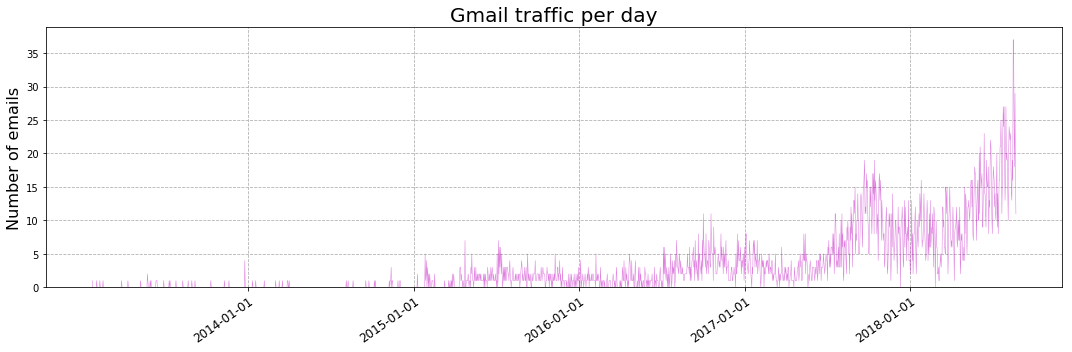

In [10]:
# plot the counts per day
fig = plt.figure(figsize=[15, 5])
ax = date_counts.plot(kind='line', linewidth=0.5, alpha=0.5, color='m')

ax.set_ylim(bottom=0)
ax.grid(True, linestyle='--')
ax.set_xticks(xlabels.index)
ax.set_xticklabels(xlabels, rotation=35, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
ax.set_ylabel('Number of emails', fontproperties=label_font)
ax.set_title('Gmail traffic per day', fontproperties=title_font)

fig.tight_layout()
fig.savefig('images/gmail-traffic-day.png', dpi=96)
plt.show()

## Plot the traffic month by month

In [11]:
# get the count per month
all_months = [x[:-3] for x in all_dates]
month_counts = pd.Series(all_months).value_counts().sort_index()

In [12]:
# not every month necessarily has a message, so fill in missing months in the range with zeros
date_range = pd.date_range(start=min(all_dates), end=max(all_dates), freq='D')
months_range = date_range.map(lambda x: str(x.date())[:-3])
index = np.unique(months_range)
month_counts = month_counts.reindex(index, fill_value=0)

In [13]:
# create a series of labels for the plot: each january
xlabels = pd.Series([label if '-01' in label else None for label in month_counts.index])
xlabels = xlabels[pd.notnull(xlabels)]
xlabels.head()

0     2013-01
12    2014-01
24    2015-01
36    2016-01
48    2017-01
dtype: object

c:\users\sonali\appdata\local\programs\python\python36-32\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


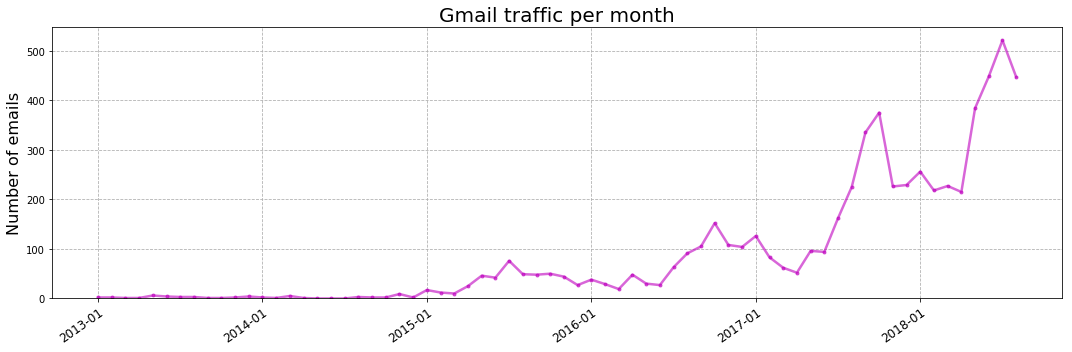

In [14]:
# plot the counts per month
fig = plt.figure(figsize=[15, 5])
ax = month_counts.plot(kind='line', linewidth=2.5, alpha=0.6, color='m', marker='.', markeredgecolor='m')

ax.set_ylim(bottom=0)
ax.grid(True, linestyle='--')
ax.set_xticks(xlabels.index)
ax.set_xticklabels(xlabels, rotation=35, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
ax.set_ylabel('Number of emails', fontproperties=label_font)
ax.set_title('Gmail traffic per month', fontproperties=title_font)

fig.tight_layout()
fig.savefig('images/gmail-traffic-month.png', dpi=96)
plt.show()

## Plot the Gmail traffic by the day of the week

In [17]:
# get the count per day of the week
day_counts = pd.DataFrame()
day_counts['count'] = date_counts
day_counts['day_of_week'] = date_counts.index.map(lambda x: parse_datetime(x).weekday())
mean_day_counts = day_counts.groupby('day_of_week')['count'].mean()
xlabels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

c:\users\sonali\appdata\local\programs\python\python36-32\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


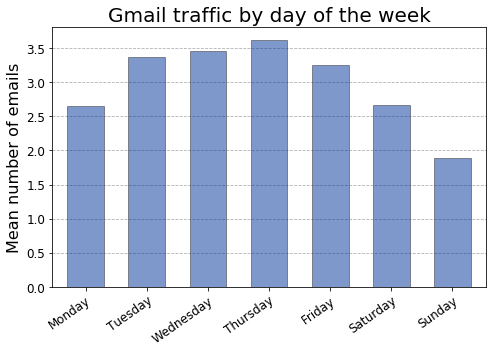

In [18]:
fig = plt.figure(figsize=[7, 5])
ax = mean_day_counts.plot(kind='bar', width=0.6, alpha=0.5, color='#003399', edgecolor='#333333', zorder=2)

ax.yaxis.grid(True, linestyle='--')
ax.set_xticklabels(xlabels, rotation=35, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_title('Gmail traffic by day of the week', fontproperties=title_font)
ax.set_xlabel('')
ax.set_ylabel('Mean number of emails', fontproperties=label_font)

fig.tight_layout()
fig.savefig('images/gmail-traffic-day-week.png', dpi=96)
plt.show()

## Plot the Gmail traffic by the hour of the day

In [19]:
# get the count per hour of the day
times = pd.Series(all_times).map(lambda x: '{:02}:00'.format(parse_datetime(x).hour))
time_counts = times.value_counts().sort_index()
time_counts.head()

00:00    232
01:00    223
02:00    292
03:00    271
04:00    278
dtype: int64

c:\users\sonali\appdata\local\programs\python\python36-32\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


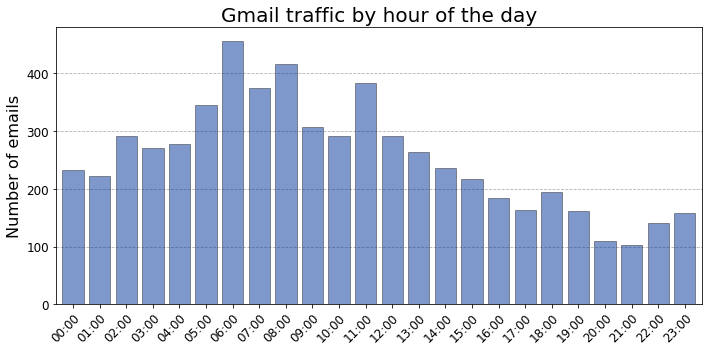

In [20]:
fig = plt.figure(figsize=[10, 5])
ax = time_counts.plot(kind='bar', width=0.8, alpha=0.5, color='#003399', edgecolor='#333333', zorder=2)

ax.yaxis.grid(True, linestyle='--')
ax.set_xticklabels(time_counts.index, rotation=45, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_title('Gmail traffic by hour of the day', fontproperties=title_font)
ax.set_ylabel('Number of emails', fontproperties=label_font)

fig.tight_layout()
fig.savefig('images/gmail-traffic-hour.png', dpi=96)
plt.show()

## Plot the Gmail traffic by the minute of the day

In [21]:
# get the count per minute of the day, as hh:mm
minutes = pd.Series(all_times).map(lambda x: '{:02}:{:02}'.format(parse_datetime(x).hour, parse_datetime(x).minute))
minute_counts = minutes.value_counts().sort_index()

In [22]:
# not every minute necessarily has a message, so fill in missing times with zeros
time_range = pd.date_range(start='0:00', end='23:59', freq='1min')
index = time_range.map(lambda x: '{:02}:{:02}'.format(x.hour, x.minute))
minute_counts = minute_counts.reindex(index, fill_value=0)

In [23]:
# create a series of labels for the plot: each new hour
xlabels = pd.Series([label if ':00' in label else None for label in minute_counts.index])
xlabels = xlabels[pd.notnull(xlabels)]

c:\users\sonali\appdata\local\programs\python\python36-32\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


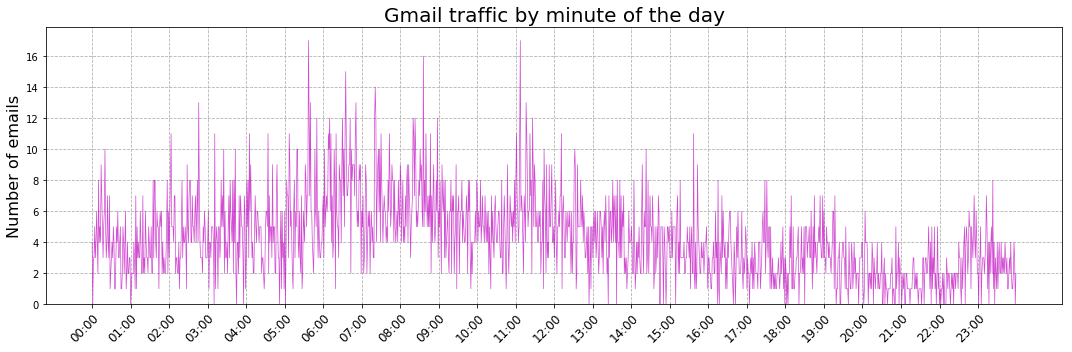

In [24]:
# plot the counts per minute
fig = plt.figure(figsize=[15, 5])
ax = minute_counts.plot(kind='line', linewidth=0.7, alpha=0.7, color='m')

ax.set_ylim(bottom=0)
ax.grid(True, linestyle='--')
ax.set_xticks(xlabels.index)
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
ax.set_ylabel('Number of emails', fontproperties=label_font)
ax.set_title('Gmail traffic by minute of the day', fontproperties=title_font)

fig.tight_layout()
fig.savefig('images/gmail-traffic-minute.png', dpi=96)
plt.show()